In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2024-01-26 14:47:41.320600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 14:47:47.157380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Download the Flowers Dataset using TensorFlow Datasets

In [2]:
(training_set, validation_set), dataset_info = tfds.load('tf_flowers',
                                                         split=['train[:70%]', 'train[70%:]'],
                                                         download=True,
                                                         with_info=True,
                                                         as_supervised=True)

2024-01-26 14:48:44.910840: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/catundertheleaf/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2024-01-26 14:48:58.464704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 14:48:58.942637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 14:48:58.942990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 14:48:58.961863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-26 14:48:58.962132: I tensorflow/compile

### Print Information about the Flowers Dataset

In [3]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = len(training_set)
num_validation_examples = len(validation_set)

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [4]:
# The images in the Flowers dataset are not all the same size.
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


2024-01-26 14:50:00.922391: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Reformat Images and Create Batches

In [5]:
IMAGE_RES = 224

def format_image(image, label):

  image = tf.image.resize(image, (IMAGE_RES,IMAGE_RES))/255.0

  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Do Simple Transfer Learning with TensorFlow Hub

In [6]:
URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-feature-vector/versions/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

feature_extractor.trainable = False

In [7]:
# Add classification to the backbone
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])


In [8]:
# train the model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6


2024-01-26 14:52:28.378119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-26 14:52:30.059303: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-26 14:52:33.960756: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bd806b2930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-26 14:52:33.960990: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2024-01-26 14:52:34.174438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-26 14:52:35.516219: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-26 14:52:35.764533: I ./tensorflow/compiler/jit/device_compile

81/81 [==============================] - 46s 378ms/step - loss: 0.7655 - accuracy: 0.7240 - val_loss: 0.4866 - val_accuracy: 0.8465
Epoch 2/6
81/81 [==============================] - 23s 282ms/step - loss: 0.3987 - accuracy: 0.8614 - val_loss: 0.4042 - val_accuracy: 0.8701
Epoch 3/6
81/81 [==============================] - 45s 552ms/step - loss: 0.3231 - accuracy: 0.8906 - val_loss: 0.3679 - val_accuracy: 0.8774
Epoch 4/6
81/81 [==============================] - 39s 474ms/step - loss: 0.2707 - accuracy: 0.9140 - val_loss: 0.3475 - val_accuracy: 0.8874
Epoch 5/6
81/81 [==============================] - 51s 625ms/step - loss: 0.2305 - accuracy: 0.9233 - val_loss: 0.3511 - val_accuracy: 0.8856
Epoch 6/6
81/81 [==============================] - 66s 815ms/step - loss: 0.2040 - accuracy: 0.9330 - val_loss: 0.3356 - val_accuracy: 0.8901


### Plot Training and Validation Graphs

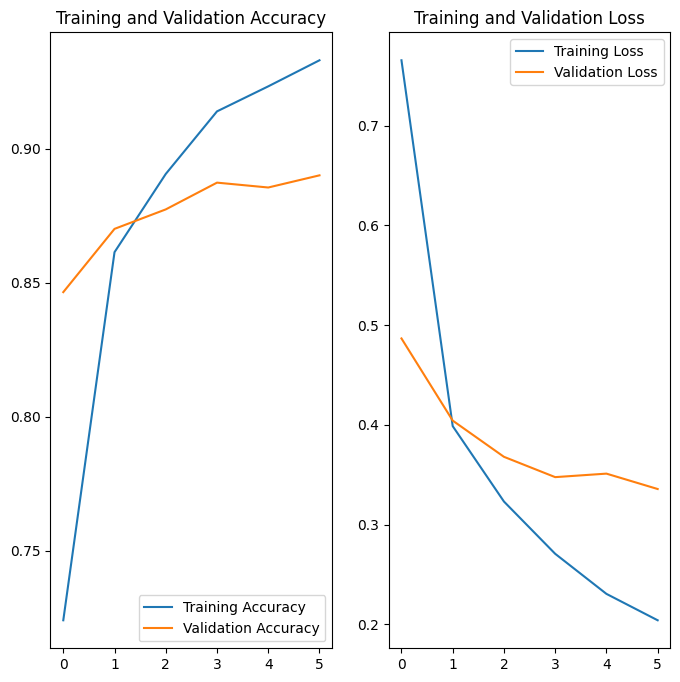

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### check predictions

In [10]:
# 
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [11]:
# Create an Image Batch and Make Predictions
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()



predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

1/1 [==============================] - 1s 1s/step


In [12]:
# Print True Labels and Predicted Indices
print(predicted_ids)
print(label_batch)

[0 1 4 3 1 1 1 3 3 1 2 2 1 3 2 3 3 1 1 4 4 1 2 2 3 4 0 2 4 1 0 4]
[0 1 4 3 1 1 1 3 3 1 2 2 1 3 2 3 3 1 2 4 4 1 2 2 3 4 0 2 4 1 0 4]


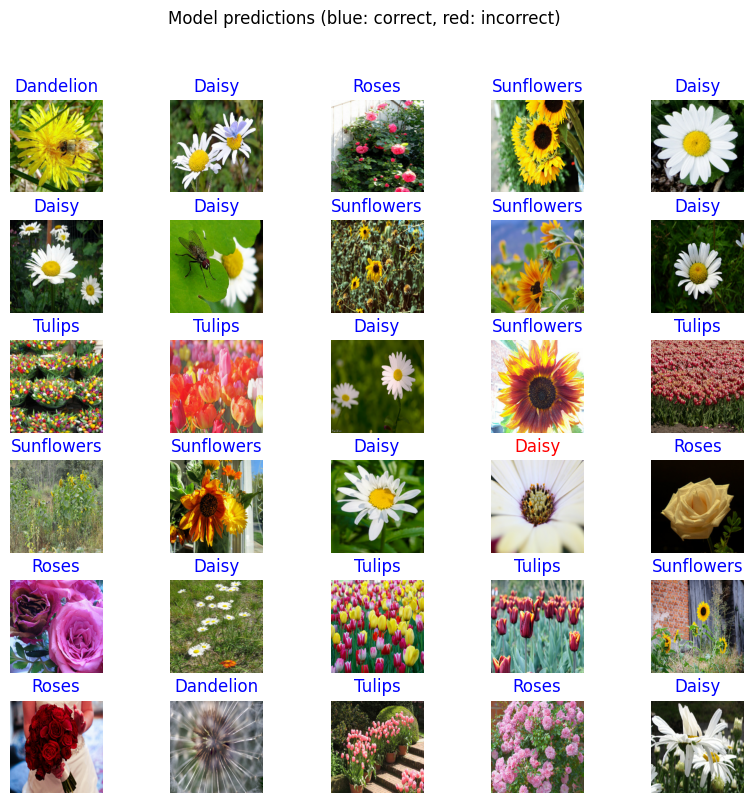

In [13]:
# Plot Model Predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")